# Real World Evidence (#67675) - Project

## Accidental death by fatal drug overdose is a rising trend in the United States. What can we do to help?

The data set used in this project was obtained from https://www.kaggle.com/apryor6/us-opiate-prescriptions

## Data

* `overdoses.csv` - Statistics on opioid related drug overdoses in 2014
* `prescriber-info.csv` - Prescription drug information by doctor in the U.S. 2014
* `opioids.csv` - List of drugs classified as opiates

## Imports

In [1]:
from matplotlib import style as style
import matplotlib.pyplot as plt
style.use('ggplot')
import pandas as pd
import numpy as np
import re
from scipy.stats import spearmanr
from sklearn.cross_validation import train_test_split
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Descriptive Statistics

### State Overdose Statistics

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


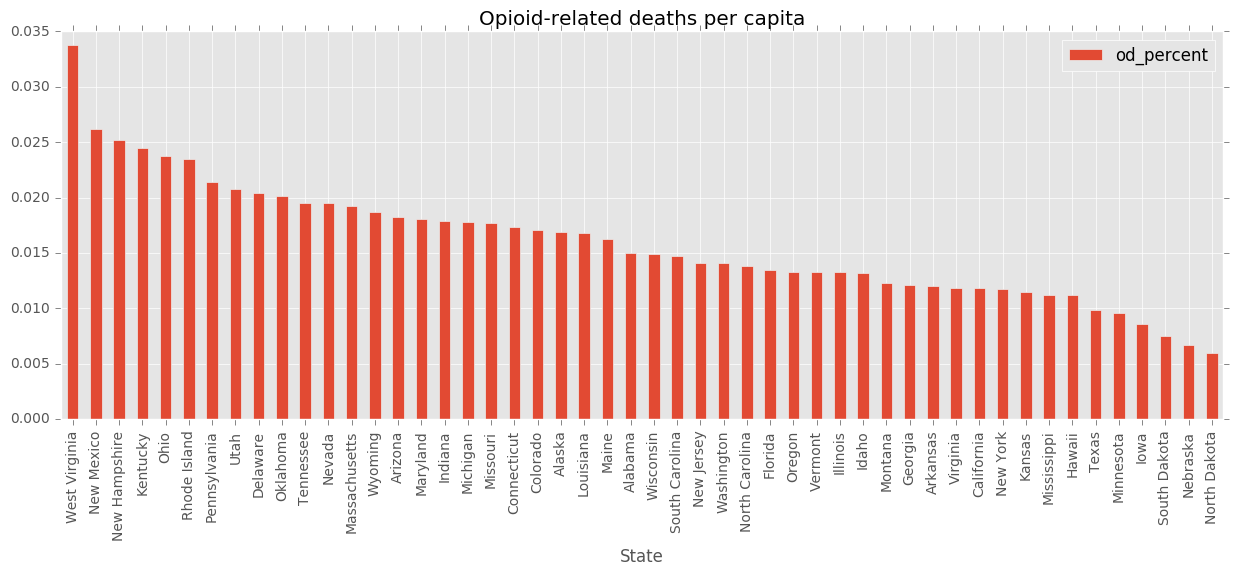

In [2]:
state_ods = pd.read_csv('data/overdoses.csv', thousands=',')
state_ods['od_percent'] = 100 * (state_ods.Deaths / state_ods.Population)
state_ods = state_ods.sort('od_percent', ascending=False)
state_ods.plot(kind='bar', x='State', y='od_percent', title="Opioid-related deaths per capita", figsize=(15,5))
show()

Focusing on the top-10 states, with respect to the percentage of opioid-related overdoses, we see a cluster of east-coast states:

![caption](img/highest_percentage_states.png)

### Prescriber Statistics

#### Cleaning the Data

In [3]:
prescriber_info = pd.read_csv('data/prescriber-info.csv', thousands=',')
# remove states with a low number of opioid prescribers
state_sizes = prescriber_info.groupby('State').size()
large_state_ops = state_sizes[state_sizes > 50]
idxs = prescriber_info.apply(lambda r: r.State in large_state_ops.index , axis=1) 
filtered_prescriber_info = prescriber_info[idxs].copy()
# merge similar\small specialties
filtered_prescriber_info = filtered_prescriber_info.replace('.*Surgery.*', 'General Surgery', regex=True)
specialty_group_sizes = filtered_prescriber_info.groupby('Specialty').size()
small_specialty_groups = specialty_group_sizes[specialty_group_sizes < 20]
filtered_prescriber_info.replace(small_specialty_groups.index, 'Other', inplace=True)
prescriber_info = filtered_prescriber_info

#### Opioid Prescribers per Capita

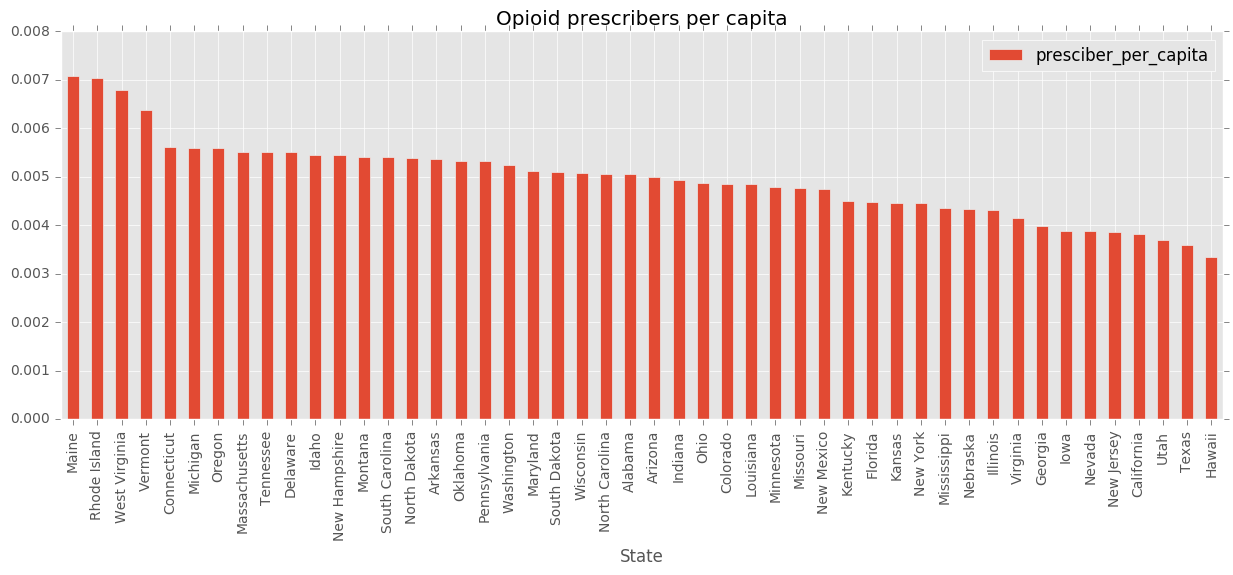

In [4]:
opiad_prescriber_idxs = prescriber_info.apply(lambda r: r['Opioid.Prescriber'] == 1, axis=1)
opiad_prescriber_info = prescriber_info[opiad_prescriber_idxs]
opiad_prescriber_state_grp = opiad_prescriber_info.groupby(['State'])
states = [sn for sn, g in opiad_prescriber_state_grp]
opiad_prescribers_state_count = pd.DataFrame({'Abbrev': states, 'num_of_prescribers': opiad_prescriber_state_grp.size()})
join_ods_prescribers = pd.merge(state_ods, opiad_prescribers_state_count, how='inner', on=['Abbrev'])
join_ods_prescribers['presciber_per_capita'] = 100 * join_ods_prescribers['num_of_prescribers'] / join_ods_prescribers['Population'] 
join_ods_prescribers = join_ods_prescribers.sort_values('presciber_per_capita', ascending=False)
join_ods_prescribers.plot(kind='bar', x='State', y='presciber_per_capita', title="Opioid prescribers per capita", figsize=(15,5))
show()

#### Correlation between opioid deaths per capita and opioid prescribers per capita 

In [5]:
ods_vs_prescribers = join_ods_prescribers[['od_percent','presciber_per_capita']]
ods_vs_prescribers_mat = ods_vs_prescribers.values.transpose()
rho, pvalue = spearmanr(ods_vs_prescribers_mat[0,:], ods_vs_prescribers_mat[1,:])
print('rho: ' + str(rho))
print('p-value: ' + str(pvalue))

rho: 0.369083803734
p-value: 0.00983612473327


#### Which field has the most amount of doctors who prescribe opioids?

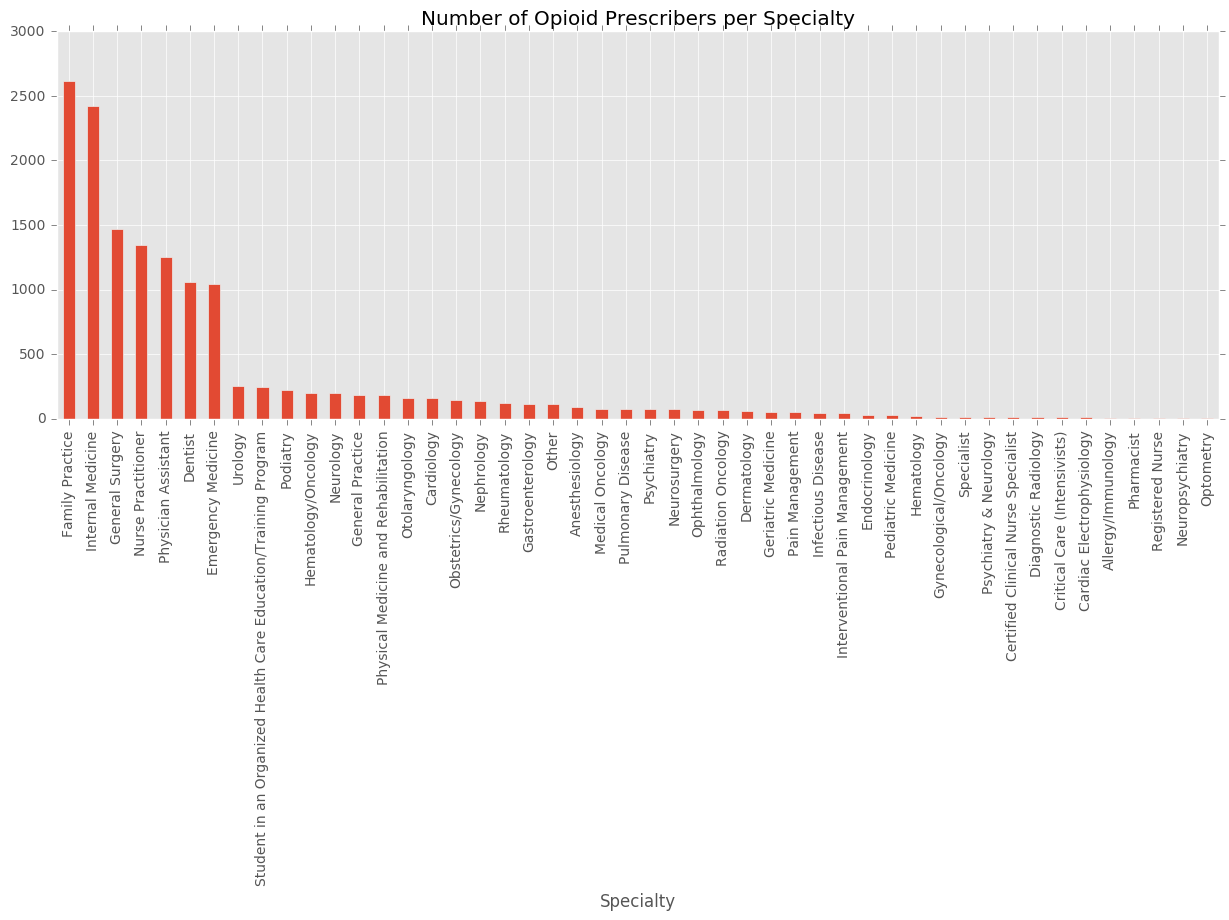

In [6]:
specialty_size = opiad_prescriber_info.groupby('Specialty').size()
specialty_size.sort_values(inplace=True, ascending=False)
specialty_size.plot(kind='bar', x='Specialty', y='num. of prescribers', 
                    title="Number of Opioid Prescribers per Specialty", figsize=(15,5))
show()

Which field has most of its doctors being opiads prescribers

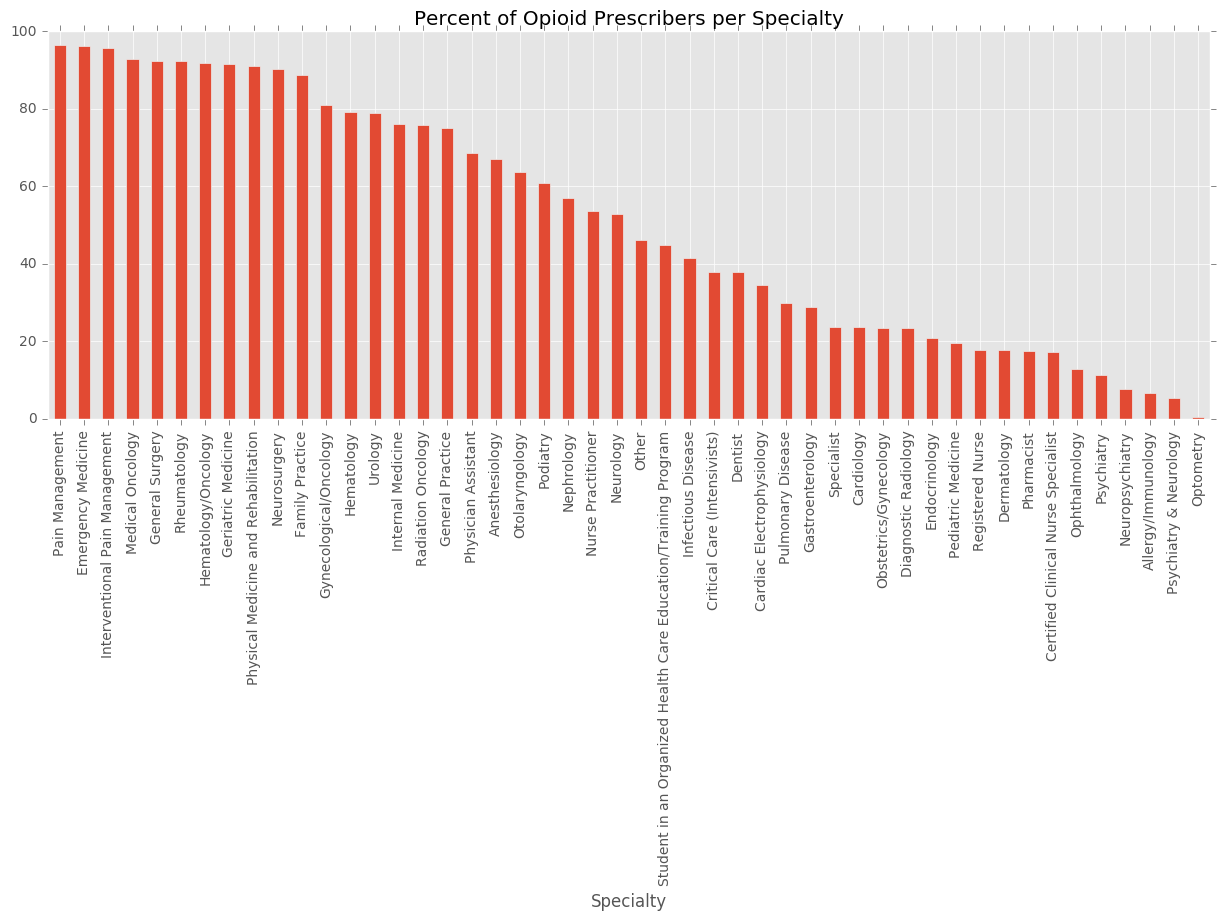

In [7]:
specialty_size = opiad_prescriber_info.groupby('Specialty').size() / prescriber_info.groupby('Specialty').size() * 100
specialty_size.sort_values(inplace=True, ascending=False)
specialty_size.plot(kind='bar', x='Specialty', y='num. of prescribers', 
                    title="Percent of Opioid Prescribers per Specialty", figsize=(15,5))
show()


### West Virginia vs. North Dakota - A Case Study

As we saw, West Virgina has the highest number of opioid-related deaths per capita, whereas North Dakota has the lower number. 

It would be interesting to compare the opioid prescription statistics in both states.  

In [8]:
opioids = pd.read_csv('data/opioids.csv')
op_names = opioids['Drug Name']
cleaned_op_names = op_names.apply(lambda name: re.sub("\ |-",".",str(name)))
prescibers_columns = prescriber_info.columns
common_drugs = set(prescibers_columns).intersection(set(cleaned_op_names))
prescriber_info_only_opioids_and_state = prescriber_info[['State'] + list(common_drugs)]
#prescriber_info_no_opioids = prescriber_info[list(set(prescriber_info.columns) - common_drugs)]
prescriber_info_no_opioids = prescriber_info.copy()
for drug in common_drugs:
    prescriber_info_no_opioids = prescriber_info_no_opioids.drop(drug, 1)
state_opioid_pres_sums = prescriber_info_only_opioids_and_state.groupby('State').sum()
WV_pop = state_ods[state_ods.Abbrev == 'WV'].Population.values
ND_pop = state_ods[state_ods.Abbrev == 'ND'].Population.values

WV_pres_norm = state_opioid_pres_sums.iloc[state_opioid_pres_sums.index.get_loc('WV')].values / WV_pop
ND_pres_norm = state_opioid_pres_sums.iloc[state_opioid_pres_sums.index.get_loc('ND')].values / ND_pop
general_prescription_ratio = sum(WV_pres_norm)/sum(ND_pres_norm)
print('Prescription ratio: ' + str(general_prescription_ratio))

Prescription ratio: 1.56228259001


We see here that in general, opioids are prescribed in West Virginia 1.5-times as much as in North Dakota.

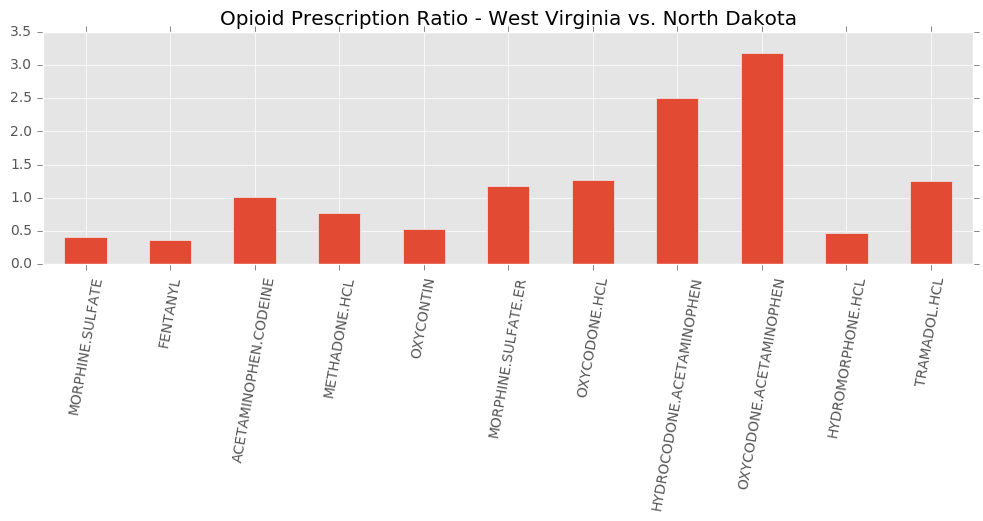

In [9]:
WV_ND_ratio = WV_pres_norm / ND_pres_norm
ratio_series = pd.Series.from_array(WV_ND_ratio)  
x_labels = state_opioid_pres_sums.columns
plt.figure(figsize=(12, 3))
ax = ratio_series.plot(kind='bar')
ax.set_title("Opioid Prescription Ratio - West Virginia vs. North Dakota")
ax.set_xticklabels(x_labels, rotation = 80)
show()

*Note that we first normalized the number of prescriptions by the total population at each state.*

This graph shows that some opioids are prescripted much more in West Virginia than in North Dakota.

Interestingly, OXYCODONE\ACETAMINOPHEN is prescribed in West Virginia more than three times as much as in North Dakota.

## Classification

### Predicting Opioid Prescriptions 

Exploring the characteristics of opioid prescribers could be helpful in several ways:
* Understanding the medical fields and specialties in which opioids are used can shed light on the areas in which  special attention and awareness is needed.   
* Understanding drug prescription connections and habits can help spot possible dangers, and bring to attention areas which should be furter researched.
* Illegal trading of opioids is a serious problem on its own, so this could be a way of discovering illegitimate drug access.

In [10]:
from sklearn.ensemble import RandomForestClassifier

prescriber_info_facts = prescriber_info.copy()
# factorize the 'Gender', 'State', 'Credentials', 'Specialty' columns so all the data will be numeric
cats_to_factorize = ['Gender', 'State', 'Credentials', 'Specialty']
prescriber_info_facts[cats_to_factorize] = prescriber_info_facts[cats_to_factorize].apply(lambda x: pd.factorize(x)[0]) 
train, test = train_test_split(prescriber_info_facts,test_size=0.2, random_state=17)
train_features = train.iloc[:, 1:-1]
train_labels = train.iloc[:,-1]
# train:
rfc = RandomForestClassifier(n_estimators=20, random_state=13)
rfc.fit(train_features, train_labels)
# test
test_features = test.iloc[:, 1:-1]
test_labels = test.iloc[:,-1]
rfc.score(test_features, test_labels)

0.92574754164158135

(254,)


(-1, 20)

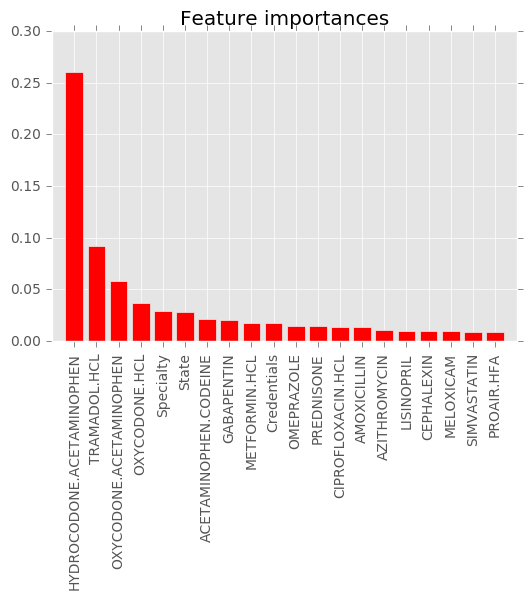

In [11]:
importances = rfc.feature_importances_
print (importances.shape)
indices = np.argsort(importances)[::-1]
column_names = list(train_features)

# for idx in indices:
#     print(column_names[idx] + " importance: %f" %importances[idx])

plt.figure()
plt.title("Feature importances")
ordered_col_names = [ column_names[i] for i in indices[:20]]
plt.bar(range(20), importances[indices][:20], color="r", align="center")
plt.xticks(range(20), ordered_col_names[:20], rotation = 90)
plt.xlim([-1, 20])

Classifiying while removing all opiodes from data

In [12]:
from sklearn.ensemble import RandomForestClassifier

prescriber_info_facts = prescriber_info_no_opioids.copy()
# factorize the 'Gender', 'State', 'Credentials', 'Specialty' columns so all the data will be numeric
cats_to_factorize = ['Gender', 'State', 'Credentials', 'Specialty']
prescriber_info_facts[cats_to_factorize] = prescriber_info_facts[cats_to_factorize].apply(lambda x: pd.factorize(x)[0]) 
train, test = train_test_split(prescriber_info_facts,test_size=0.2, random_state=17)
train_features = train.iloc[:, 1:-1]
train_labels = train.iloc[:,-1]
# train:
rfc = RandomForestClassifier(n_estimators=20, random_state=13)
rfc.fit(train_features, train_labels)
# test
test_features = test.iloc[:, 1:-1]
test_labels = test.iloc[:,-1]
rfc.score(test_features, test_labels)

0.83905277945013046

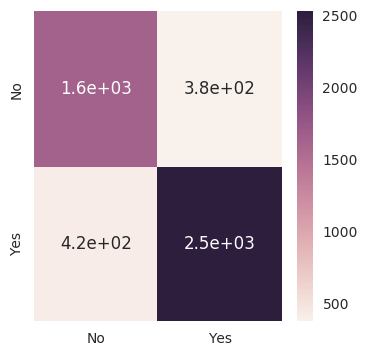

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
pred = rfc.predict(test_features)
conf_mat = confusion_matrix(pred, test_labels)
df_cm = pd.DataFrame(conf_mat, index = [item for item in ['No','Yes']],
                     columns = [item for item in ['No','Yes']])
plt.figure(figsize = (4,4))
sn.heatmap(df_cm, annot=True)

Showing the important features

(243,)


(-1, 20)

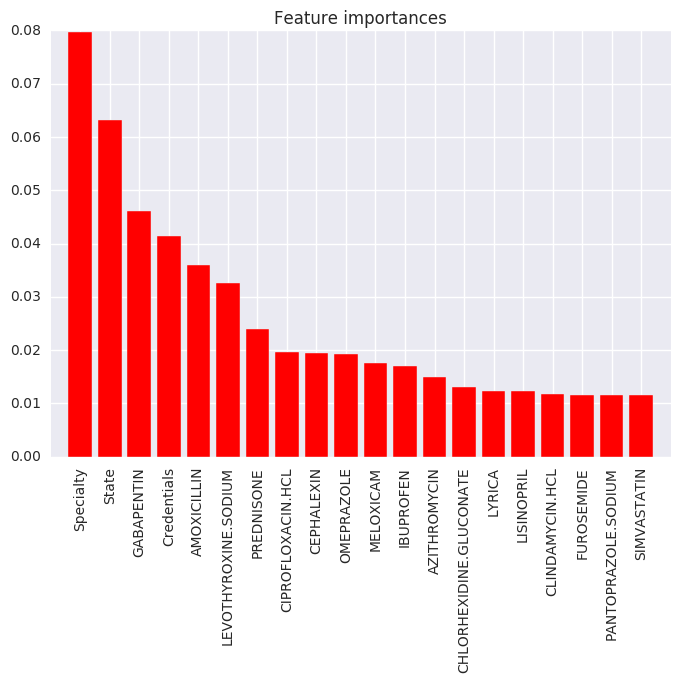

In [14]:
importances = rfc.feature_importances_
print (importances.shape)
indices = np.argsort(importances)[::-1]
column_names = list(train_features)

# for idx in indices:
#     print(column_names[idx] + " importance: %f" %importances[idx])

plt.figure()
plt.title("Feature importances")
ordered_col_names = [ column_names[i] for i in indices[:20]]
plt.bar(range(20), importances[indices][:20], color="r", align="center")
plt.xticks(range(20), ordered_col_names[:20], rotation = 90)
plt.xlim([-1, 20])

Opioid.Prescriber
0    17.733249
1    18.856733
Name: State, dtype: float64


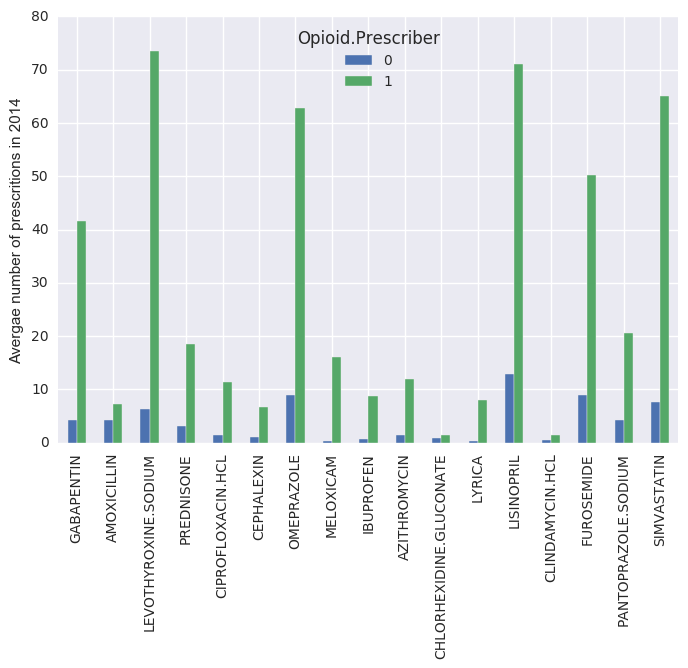

In [15]:
mean_docs = prescriber_info_facts.groupby('Opioid.Prescriber').mean()
print (mean_docs['State'])
relevant_stats = [mean_docs[feature] for feature in ordered_col_names[:20] if feature not in ['State', 'Specialty', 'Credentials']]
ax = pd.DataFrame(relevant_stats).plot(kind="bar")
ax.set_ylabel("Avergae number of prescritions in 2014")

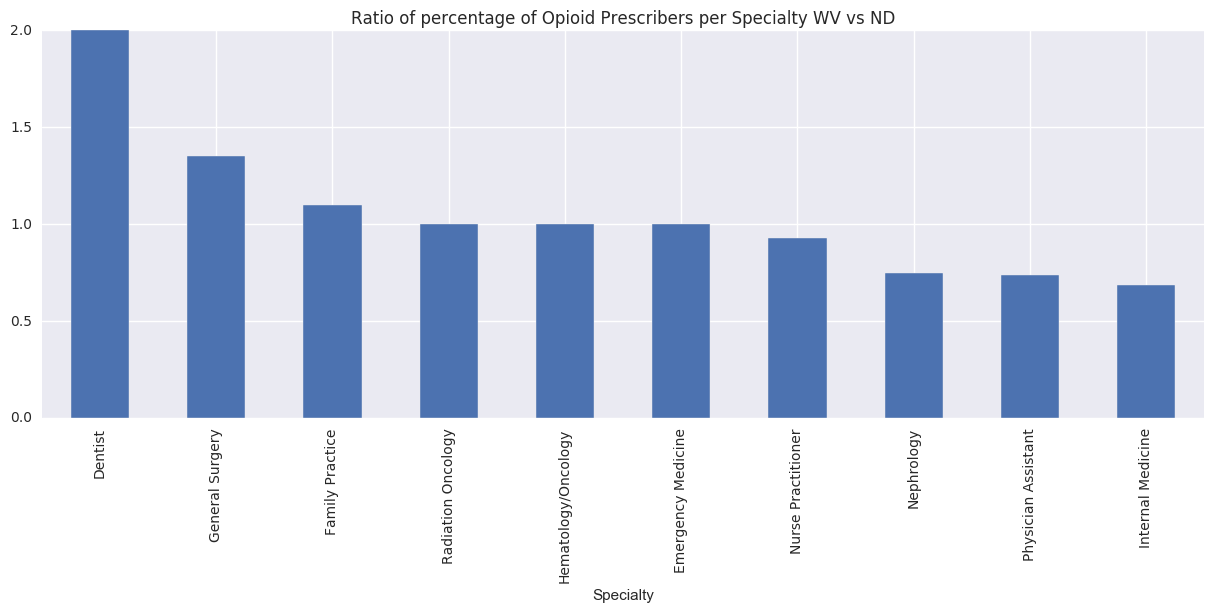

In [16]:
wv_specialty_size = (opiad_prescriber_info[(opiad_prescriber_info['State']=='WV')].groupby('Specialty').size() /
                     prescriber_info[(prescriber_info['State']=='WV')].groupby('Specialty').size() * 100)
wv_specialty_size= wv_specialty_size.dropna()
nd_specialty_size = (opiad_prescriber_info[(opiad_prescriber_info['State']=='ND')].groupby('Specialty').size() /
                     prescriber_info[(prescriber_info['State']=='ND')].groupby('Specialty').size() * 100)
nd_specialty_size = nd_specialty_size.dropna()
# print (wv_specialty_size)
# print (nd_specialty_size)
keys =  wv_specialty_size.keys() & nd_specialty_size.keys()
ratio = wv_specialty_size[keys] / nd_specialty_size[keys]
ratio.sort_values(inplace=True, ascending=False)
ratio.plot(kind='bar', x='Specialty', y='num. of prescribers', 
                    title="Ratio of percentage of Opioid Prescribers per Specialty WV vs ND", figsize=(15,5))

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


1.1195460211966064


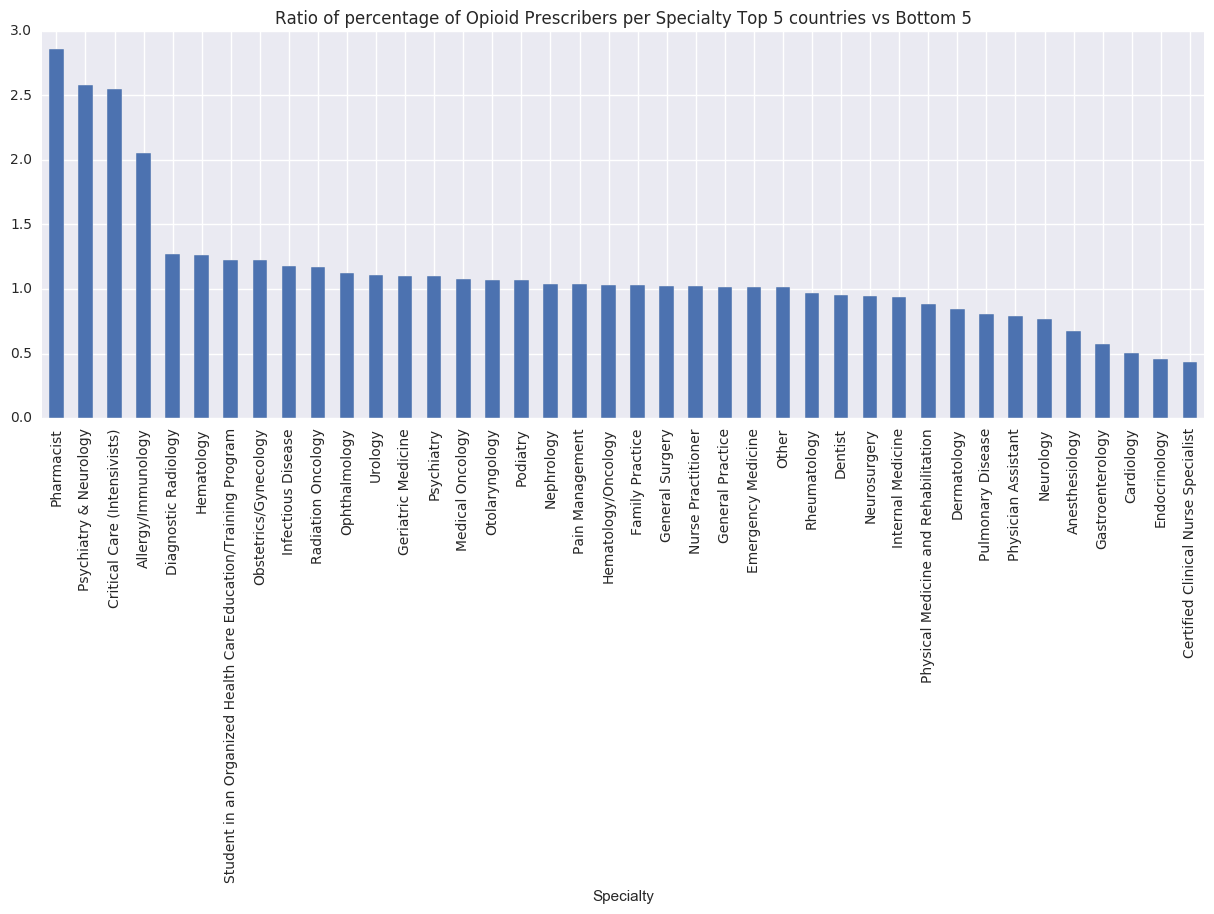

In [18]:
state_ods = pd.read_csv('data/overdoses.csv', thousands=',')
state_ods['od_percent'] = 100 * (state_ods.Deaths / state_ods.Population)
state_ods = state_ods.sort('od_percent', ascending=False)
top_10_states = list(state_ods['Abbrev'][:5])
bot_10_states = list(state_ods['Abbrev'][:-5])
top_10_specialty_size = (opiad_prescriber_info[(opiad_prescriber_info['State'].isin(top_5_states))].groupby('Specialty').size() /
                     prescriber_info[(prescriber_info['State'].isin(top_10_states))].groupby('Specialty').size() * 100)
top_10_specialty_size = top_10_specialty_size.dropna()
bot_10_specialty_size = (opiad_prescriber_info[(opiad_prescriber_info['State'].isin(bot_5_states))].groupby('Specialty').size() /
                     prescriber_info[(prescriber_info['State'].isin(bot_10_states))].groupby('Specialty').size() * 100)
bot_10_specialty_size = bot_10_specialty_size.dropna()
keys =  top_10_specialty_size.keys() & bot_10_specialty_size.keys()
ratio = top_10_specialty_size[keys] / bot_10_specialty_size[keys]
print (ratio.mean())
ratio.sort_values(inplace=True, ascending=False)
ratio.plot(kind='bar', x='Specialty', y='num. of prescribers', 
                    title="Ratio of percentage of Opioid Prescribers per Specialty Top 5 countries vs Bottom 5", figsize=(15,5))

In [19]:
import gensim
opiad_prescriber_idxs = prescriber_info.apply(lambda r: r['Opioid.Prescriber'] == 1, axis=1)
opiad_prescriber_info = prescriber_info[opiad_prescriber_idxs]
non_opiad_prescriber_idxs = prescriber_info.apply(lambda r: r['Opioid.Prescriber'] == 0, axis=1)
non_opiad_prescriber_info = prescriber_info[non_opiad_prescriber_idxs]

def create_lda_dicts(data):
    drug_col_names = list(data.loc[:,'ABILIFY':'ZOLPIDEM.TARTRATE'].columns.values)
    drugs_names_dict = dict()
    for i, name in enumerate(drug_col_names):
        drugs_names_dict[i] = name
    drugs_data = data.loc[:,'ABILIFY':'ZOLPIDEM.TARTRATE'].values
    drugs_data_tup = []
    for i in range(len(drugs_data)):
        drugs_data_tup.append([])
        for j in range(len(drugs_data[i])):
            if  drugs_data[i,j]>0:
                drugs_data_tup[-1].append((j, drugs_data[i,j]))
    return drugs_names_dict, drugs_data_tup

drugs_names_dict_opiod, drugs_data_tup_opiod = create_lda_dicts(opiad_prescriber_info)
ldamodel_opiod = gensim.models.ldamodel.LdaModel(drugs_data_tup_opiod, num_topics=4, 
                                                 id2word = drugs_names_dict_opiod, passes=20)

drugs_names_dict_non_opiod, drugs_data_tup_non_opiod = create_lda_dicts(non_opiad_prescriber_info)
ldamodel_non_opiod = gensim.models.ldamodel.LdaModel(drugs_data_tup_non_opiod, num_topics=4, 
                                                     id2word = drugs_names_dict_non_opiod, passes=20)

C:\Program Files\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [22]:
topics = ldamodel_opiod.print_topics(num_topics=4, num_words=4)
for item in topics:
    print (item)

(0, '0.050*"LISINOPRIL" + 0.050*"LEVOTHYROXINE.SODIUM" + 0.048*"AMLODIPINE.BESYLATE" + 0.046*"SIMVASTATIN"')
(1, '0.269*"HYDROCODONE.ACETAMINOPHEN" + 0.079*"OXYCODONE.ACETAMINOPHEN" + 0.070*"GABAPENTIN" + 0.058*"OXYCODONE.HCL"')
(2, '0.042*"DONEPEZIL.HCL" + 0.036*"CLONAZEPAM" + 0.036*"GABAPENTIN" + 0.034*"OMEPRAZOLE"')
(3, '0.106*"PREDNISONE" + 0.094*"TAMSULOSIN.HCL" + 0.064*"CIPROFLOXACIN.HCL" + 0.049*"FINASTERIDE"')


In [23]:
topics = ldamodel_non_opiod.print_topics(num_topics=4, num_words=4)
for item in topics:
    print (item)

(0, '0.073*"FLUTICASONE.PROPIONATE" + 0.062*"MONTELUKAST.SODIUM" + 0.057*"SPIRIVA" + 0.055*"PREDNISONE"')
(1, '0.154*"OMEPRAZOLE" + 0.095*"LEVOTHYROXINE.SODIUM" + 0.060*"METFORMIN.HCL" + 0.059*"PANTOPRAZOLE.SODIUM"')
(2, '0.066*"CLONAZEPAM" + 0.057*"QUETIAPINE.FUMARATE" + 0.055*"TRAZODONE.HCL" + 0.050*"RISPERIDONE"')
(3, '0.073*"ATORVASTATIN.CALCIUM" + 0.070*"LATANOPROST" + 0.058*"LISINOPRIL" + 0.056*"AMLODIPINE.BESYLATE"')
